### Hidden Markov Models

author: Jacob Schreiber <br>
contact: jmschreiber91@gmail.com

Hidden Markov models (HMMs) are a probability distribution over sequences that are made up of two components: a set of probability distributions and a transition matrix (sometimes represented as a graph) describing how sequences can proceed through the model. HMMs are the flagship implementation in pomegranate and were the first algorithm originally implemented.

HMMs are a form of structured prediction method that are popular for tagging all elements in a sequence with some "hidden" state. They can be thought of as extensions of Markov chains where, instead of the probability of the next observation being dependant on the current observation, the probability of the next hidden state is dependant on the current hidden state, and the next observation is derived from that hidden state. An example of this can be part of speech tagging, where the observations are words and the hidden states are parts of speech. Each word gets tagged with a part of speech, but dynamic programming is utilized to search through all potential word-tag combinations to identify the best set of tags across the entire sentence.

In [1]:
%pylab inline
import seaborn; seaborn.set_style('whitegrid')

import torch

from torchegranate.hmm import HiddenMarkovModel, Node
from torchegranate.distributions import *


numpy.random.seed(0)
numpy.set_printoptions(suppress=True)

%load_ext watermark
%watermark -m -n -p numpy,scipy,torch,torchegranate

Populating the interactive namespace from numpy and matplotlib
numpy        : 1.23.4
scipy        : 1.9.3
torch        : 1.12.1
torchegranate: 0.0.1

Compiler    : GCC 11.2.0
OS          : Linux
Release     : 4.15.0-197-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 8
Architecture: 64bit



### Identification of GC-rich regions of the genome

Lets take the simplified example of CG island detection on a sequence of DNA. DNA is made up of the four canonical nucleotides, abbreviated 'A', 'C', 'G', and 'T'. We can say that regions of the genome that are enriched for nucleotides 'C' and 'G' are 'CG islands', which is a simplification of the real biological concept but sufficient for our example. The issue with identifying these regions is that they are not exclusively made up of the nucleotides 'C' and 'G', but have some 'A's and 'T's scatted amongst them. A simple model that looked for long stretches of C's and G's would not perform well, because it would miss most of the real regions.

We can start off by building the model. Because HMMs involve the transition matrix, which is often represented using a graph over the hidden states, building them requires a few more steps that a simple distribution or the mixture model. Our simple model will be composed of two distributions. One distribution wil be a uniform distribution across all four characters and one will have a preference for the nucleotides C and G, while still allowing the nucleotides A and T to be present.

In [2]:
d1 = Categorical([[0.25, 0.25, 0.25, 0.25]])
d2 = Categorical([[0.10, 0.40, 0.40, 0.10]])

As we'll discuss below, there are two ways to initialize a HMM. One way is to create a series of node objects and add them, along with the edges of a graph, one at a time.

In [3]:
n1 = Node(d1, "background")
n2 = Node(d2, "CG island")

Now we can define the HMM and pass in states.

In [4]:
model = HiddenMarkovModel()
model.add_nodes([n1, n2])

Then we have to define the transition matrix, which is the probability of going from one hidden state to the next hidden state. In some cases, like this one, there are high self-loop probabilities, indicating that it's likely that one will stay in the same hidden state from one observation to the next in the sequence. Other cases have a lower probability of staying in the same state, like the part of speech tagger. A part of the transition matrix is the start probabilities, which is the probability of starting in each of the hidden states. Because we create these transitions one at a time, they are very amenable to sparse transition matrices, where it is impossible to transition from one hidden state to the next.

In [5]:
model.add_edge(model.start, n1, 0.5)
model.add_edge(model.start, n2, 0.5)
model.add_edge(n1, n1, 0.9)
model.add_edge(n1, n2, 0.1)
model.add_edge(n2, n1, 0.1)
model.add_edge(n2, n2, 0.9)

Now, finally, we need to bake the model in order to finalize the internal structure. Bake must be called when the model has been fully specified.

In [6]:
model.bake()

Now we can create a sequence to run through the model. Make sure that this sequence has been converted to a numeric representation of categories. This can be done either simply, as below, or using a preprocessing tool from some other package like scikit-learn. Also, make sure that your input sequence is 3D with the three dimensions corresponding to (batch_size, sequence length, dimensionality). Here, batch_size and dimensionality are both 1. The inclusion of batch size helps significantly when processing several sequences in parallel.

In [7]:
sequence = 'CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC'
X = numpy.array([[[['A', 'C', 'G', 'T'].index(char)] for char in sequence]])
X.shape

(1, 51, 1)

Now we can make predictions on some sequence. Let's create some sequence that has a CG enriched region in the middle and see whether we can identify it.

In [8]:
y_hat = model.predict(X)

print("sequence: {}".format(''.join(sequence)))
print("hmm pred: {}".format(''.join([str(y.item()) for y in y_hat[0]])))

sequence: CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC
hmm pred: 000000000000000111111111111111100000000000000001111


It looks like it successfully identified a CG island in the middle (the long stretch of 0's) and another shorter one at the end. More importantly, the model wasn't tricked into thinking that every CG or even pair of CGs was an island. It required many C's and G's to be part of a longer stretch to identify that region as an island. Naturally, the balance of the transition and emission probabilities will heavily influence what regions are detected.

Let's say, though, that we want to get rid of that CG island prediction at the end because we don't believe that real islands can occur at the end of the sequence. We can take care of this by adding in an explicit end state that only the non-island hidden state can get to. We enforce that the model has to end in the end state, and if only the non-island state gets there, the sequence of hidden states must end in the non-island state. Here's how:

In [9]:
model = HiddenMarkovModel()
model.add_nodes([n1, n2])
model.add_edge(model.start, n1, 0.5)
model.add_edge(model.start, n2, 0.5)
model.add_edge(n1, n1, 0.89 )
model.add_edge(n1, n2, 0.10 )
model.add_edge(n1, model.end, 0.01)
model.add_edge(n2, n1, 0.1 )
model.add_edge(n2, n2, 0.9)
model.bake()

Note that all we did was add a transition from n1 to model.end with some low probability. This probability doesn't have to be high if there's only a single transition there, because there's no other possible way of getting to the end state.

In [10]:
y_hat = model.predict(X)

print("sequence: {}".format(''.join(sequence)))
print("hmm pred: {}".format(''.join([str(y.item()) for y in y_hat[0]])))

sequence: CGACTACTGACTACTCGCCGACGCGACTGCCGTCTATACTGCGCATACGGC
hmm pred: 000000000000000111111111111111100000000000000000000


This seems far more reasonable. There is a single CG island surrounded by background sequence, and something at the end. If we knew that CG islands cannot occur at the end of sequences, we need only modify the underlying structure of the HMM in order to say that the sequence must end from the background state.

In the same way that mixtures could provide probabilistic estimates of class assignments rather than only hard labels, hidden Markov models can do the same. These estimates are the posterior probabilities of belonging to each of the hidden states given the observation, but also given the rest of the sequence.

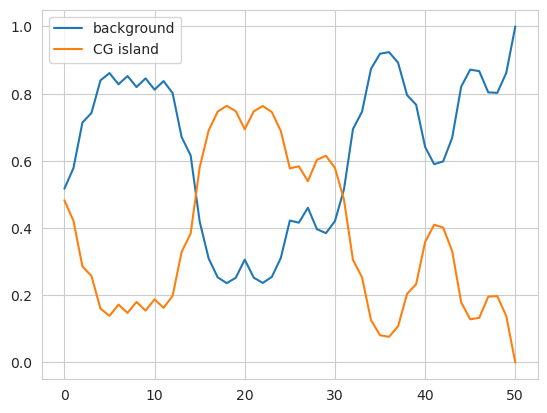

In [11]:
plt.plot(model.predict_proba(X)[0], label=['background', 'CG island'])
plt.legend()
plt.show()

We can see here the transition from the first non-island region to the middle island region, with high probabilities in one column turning into high probabilities in the other column. The predict method is just taking the most likely element --- the maximum-a-posteriori estimate.

In addition to using the forward-backward algorithm to just calculate posterior probabilities for each observation, we can count the number of transitions that are predicted to occur across each edge.

In [12]:
transitions = model.forward_backward(X)[0][0]
transitions

tensor([28.9105,  2.4129,  2.8956, 15.7810], dtype=torch.float64)

### Initializing Hidden Markov Models

There are two ways to initialize an HMM using pomegranate. The first is to explicitly pass a list of distributions, a dense transition matrix, and optionally start and end probabilities. We can recreate the above model using this approach.

In [13]:
model = HiddenMarkovModel([n1, n2], edges=[[0.89, 0.1], [0.1, 0.9]], starts=[0.5, 0.5], ends=[0.01, 0.0])
model.bake()

We can check that this initialization produces the same model by making the same plot of predicted probabilities across the sequence.

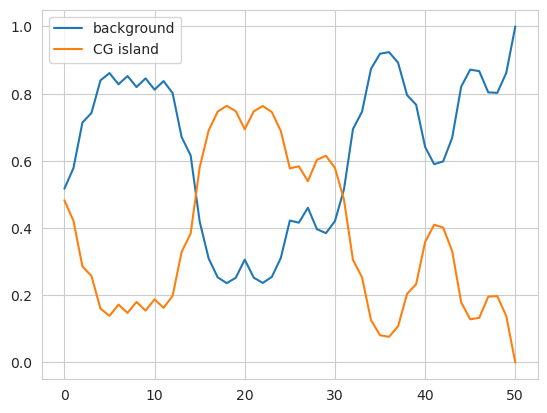

In [14]:
plt.plot(model.predict_proba(X)[0], label=['background', 'CG island'])
plt.legend()
plt.show()

The second way is to follow the procedure outlined above where you first create an uninitialized model with nothing passed into it and then you add the nodes and edges using the appropriate methods. This can be useful if you are creating an HMM with a sparse transition matrix and many nodes, or if you are trying to procedurally generate an HMM based on some external factors. Here is the same code as before that implements the HMM using this approach.

In [15]:
model = HiddenMarkovModel()
model.add_nodes([n1, n2])
model.add_edge(model.start, n1, 0.5)
model.add_edge(model.start, n2, 0.5)
model.add_edge(n1, n1, 0.89 )
model.add_edge(n1, n2, 0.10 )
model.add_edge(n1, model.end, 0.01)
model.add_edge(n2, n1, 0.1 )
model.add_edge(n2, n2, 0.9)
model.bake()

Similar to other methods, we can create an HMM with uninitialized distributions. These distributions will be initialized using k-means clustering when provided with data. We can also not pass in edges or start/end probabilities, to which these will all be initialized with uniform probabilities.

In [16]:
X3 = torch.randn(100, 50, 2)

model3 = HiddenMarkovModel([Normal(), Normal(), Normal()], kind='dense', verbose=True)
model3.bake()

model3._initialize(X3)
model3.nodes[0].distribution.means, model3.nodes[1].distribution.means, model3.nodes[2].distribution.means

/home/jmschr/anaconda3/lib/python3.9/site-packages/torchegranate-0.0.1-py3.9.egg/torchegranate/_dense_hmm.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/jmschr/anaconda3/lib/python3.9/site-packages/torchegranate-0.0.1-py3.9.egg/torchegranate/_dense_hmm.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/jmschr/anaconda3/lib/python3.9/site-packages/torchegranate-0.0.1-py3.9.egg/torchegranate/_dense_hmm.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


(tensor([-0.4901, -0.9306]),
 tensor([1.2539, 0.1061]),
 tensor([-0.3370,  0.7326]))

You can control how the k-means itself is initialized by passing in a value to `init`.

However, you do not need to manually initialize your models. If you call the `fit` method or the `summarize` method, these distributions will be initialized if they have not yet been.

In [17]:
X3 = torch.randn(100, 50, 2)

model3 = HiddenMarkovModel([Normal(), Normal(), Normal()], kind='dense', max_iter=5, verbose=True)
model3.bake()

model3.fit(X3)

[1] Improvement: 84.92519254411673, Time: 0.01265s
[2] Improvement: 67.9878352441865, Time: 0.04197s
[3] Improvement: 29.982845969290793, Time: 0.009677s
[4] Improvement: 16.392566044271007, Time: 0.008249s
[5] Improvement: 10.134997190680224, Time: 0.01866s


HiddenMarkovModel(
  (start): Node()
  (end): Node()
  (_model): _DenseHMM(
    (start): Node()
    (end): Node()
  )
)

#### Dense and Sparse HMMs

Separately from the way that the HMM is initialized, the transition matrix can be represented using a sparse matrix or a dense matrix. Although a dense transition matrix can be pretty fast for a matrix without that many zeroes in it because the internals are implemented as a matrix multiplication, once there are enough zeroes in it the computation becomes faster to simply ignore those edges.

Regardless of how you initialize the model -- meaning even if you pass in a full matrix -- you can specify which implementation you'd like to use with the `kind` parameter. If you pass in a full matrix and use `kind='sparse'`, the non-zero edges will be extracted from the given matrix. Likewise, if you specify `kind='dense'` but build the transition matrix using the methods, the internally stored list of edges gets converted to a full matrix. This makes it easy for you to compare the speed of each implementation. Both should provide the same answers, even when using a dense implementation for a transition matrix with many zeroes or a sparse implementation of a transition matrix with no zeroes.

The default initialization uses a sparse transition matrix in the backend.

In [18]:
edges = [[0.89, 0.1], [0.1, 0.9]]
starts = [0.5, 0.5]
ends = [0.01, 0.0]

model1 = HiddenMarkovModel([n1, n2], edges=edges, starts=starts, ends=ends, kind='dense')
model1.bake()

model1.predict_proba(X)[0][12:19]

tensor([[0.8016, 0.1984],
        [0.6708, 0.3292],
        [0.6163, 0.3837],
        [0.4196, 0.5804],
        [0.3092, 0.6908],
        [0.2535, 0.7465],
        [0.2361, 0.7639]], dtype=torch.float64)

In [19]:
model2 = HiddenMarkovModel([n1, n2], edges=edges, starts=starts, ends=ends, kind='sparse')
model2.bake()

model2.predict_proba(X)[0][12:19]

tensor([[0.8016, 0.1984],
        [0.6708, 0.3292],
        [0.6163, 0.3837],
        [0.4196, 0.5804],
        [0.3092, 0.6908],
        [0.2535, 0.7465],
        [0.2361, 0.7639]], dtype=torch.float64)

In [20]:
X = numpy.random.choice(4, size=(1000, 500, 1))

%timeit model1.predict_proba(X)
%timeit model2.predict_proba(X)

113 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
239 ms ± 48.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Check out the benchmarks folder to see a more thorough comparison of the two, but it looks like even for a tiny model that the dense transition matrix is around twice as fast.

### Fitting Hidden Markov Models

Hidden Markov models are usually fit to unlabeled data using the Baum-Welch algorithm. This is a structured EM algorithm that accounts for transitions between distributions as well as the distribution parameters themselves. Essentially, one uses the forward-backward algorithm to infer the expected number of transitions across each edge and the expected probability of each observation aligning to each state and uses those estimates to update the underlying parameters.

In [21]:
d1 = Categorical([[0.25, 0.25, 0.25, 0.25]])
d2 = Categorical([[0.10, 0.40, 0.40, 0.10]])

edges = [[0.89, 0.1], [0.1, 0.9]]
starts = [0.5, 0.5]
ends = [0.01, 0.0]

model = HiddenMarkovModel([d1, d2], edges=edges, starts=starts, ends=ends, kind='dense', verbose=True)
model.bake()

model.fit(X)

[1] Improvement: 16405.76230634225, Time: 0.1171s
[2] Improvement: 419.1128934014123, Time: 0.1186s
[3] Improvement: 208.4082686578622, Time: 0.1467s
[4] Improvement: 118.25163965555839, Time: 0.1261s
[5] Improvement: 73.40183741366491, Time: 0.1436s
[6] Improvement: 48.75193548516836, Time: 0.117s
[7] Improvement: 33.98372272506822, Time: 0.1508s
[8] Improvement: 24.710323460865766, Time: 0.1942s
[9] Improvement: 18.501670305035077, Time: 0.1363s
[10] Improvement: 14.261804573819973, Time: 0.1267s
[11] Improvement: 11.213328058598563, Time: 0.1417s
[12] Improvement: 8.96379129437264, Time: 0.1099s
[13] Improvement: 7.3336968758376315, Time: 0.1266s
[14] Improvement: 6.00325969432015, Time: 0.133s
[15] Improvement: 5.044057338614948, Time: 0.2043s
[16] Improvement: 4.262814470566809, Time: 0.1415s
[17] Improvement: 3.6413992885500193, Time: 0.1459s
[18] Improvement: 3.129116208408959, Time: 0.1247s
[19] Improvement: 2.6883019560482353, Time: 0.1461s
[20] Improvement: 2.3687112852931023

HiddenMarkovModel(
  (start): Node()
  (end): Node()
  (_model): _DenseHMM(
    (start): Node()
    (end): Node()
  )
)

We can change the number of iterations by setting either the `max_iter` parameter or the `tol` parameter.

In [22]:
d1 = Categorical([[0.25, 0.25, 0.25, 0.25]])
d2 = Categorical([[0.10, 0.40, 0.40, 0.10]])

edges = [[0.89, 0.1], [0.1, 0.9]]
starts = [0.5, 0.5]
ends = [0.01, 0.0]

model = HiddenMarkovModel([d1, d2], edges=edges, starts=starts, ends=ends, max_iter=5, kind='dense', verbose=True)
model.bake()

model.fit(X)

[1] Improvement: 16405.76230634225, Time: 0.1239s
[2] Improvement: 419.1128934014123, Time: 0.1105s
[3] Improvement: 208.4082686578622, Time: 0.2135s
[4] Improvement: 118.25163965555839, Time: 0.1688s
[5] Improvement: 73.40183741366491, Time: 0.2985s


HiddenMarkovModel(
  (start): Node()
  (end): Node()
  (_model): _DenseHMM(
    (start): Node()
    (end): Node()
  )
)

In [23]:
d1 = Categorical([[0.25, 0.25, 0.25, 0.25]])
d2 = Categorical([[0.10, 0.40, 0.40, 0.10]])

edges = [[0.89, 0.1], [0.1, 0.9]]
starts = [0.5, 0.5]
ends = [0.01, 0.0]

model = HiddenMarkovModel([d1, d2], edges=edges, starts=starts, ends=ends, tol=50, kind='dense', verbose=True)
model.bake()

model.fit(X)

[1] Improvement: 16405.76230634225, Time: 0.131s
[2] Improvement: 419.1128934014123, Time: 0.111s
[3] Improvement: 208.4082686578622, Time: 0.1245s
[4] Improvement: 118.25163965555839, Time: 0.1247s
[5] Improvement: 73.40183741366491, Time: 0.144s
[6] Improvement: 48.75193548516836, Time: 0.1251s


HiddenMarkovModel(
  (start): Node()
  (end): Node()
  (_model): _DenseHMM(
    (start): Node()
    (end): Node()
  )
)